In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [3]:
raw_data = pd.read_csv('train.csv')

In [4]:
X = raw_data

In [5]:
X.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID           175000 non-null  int64  
 8   DOLocationID           175000 non-null  int64  
 9   payment_type           175000 non-null  object 
 10  extra                  175000 non-null  float64
 11  tip_amount             175000 non-null  float64
 12  tolls_amount           175000 non-null  float64
 13  improvement_surcharge  175000 non-null  float64
 14  total_amount           175000 non-nu

In [7]:
datetime_format = "%Y-%m-%d %H:%M:%S"
X['tpep_pickup_datetime'] = X['tpep_pickup_datetime'].apply(lambda x: datetime.strptime(x,datetime_format))
X['tpep_dropoff_datetime'] = X['tpep_dropoff_datetime'].apply(lambda x: datetime.strptime(x,datetime_format))

In [8]:
X['Duration'] = X.apply(lambda row: max(row['tpep_pickup_datetime'],row['tpep_dropoff_datetime']) - min(row['tpep_pickup_datetime'],row['tpep_dropoff_datetime']),axis=1)

In [9]:
X['Duration_hours'] = X['Duration'].dt.seconds/3600

<AxesSubplot:xlabel='Duration_hours', ylabel='total_amount'>

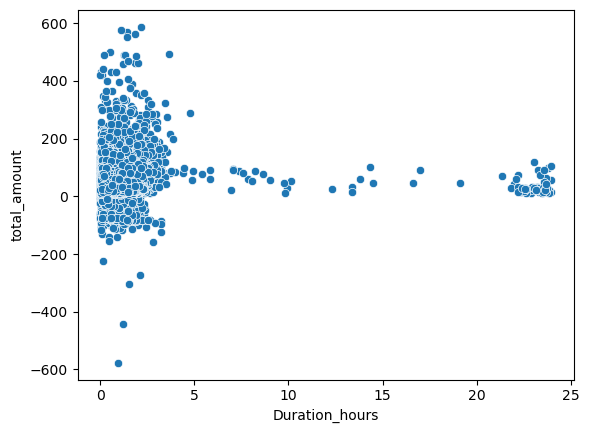

In [10]:
sns.scatterplot(x = X['Duration_hours'],y = X['total_amount'])

In [11]:
#For simplicity, removing outliers
X.drop(X[X['Duration_hours'] > 5].index, inplace=True)

<AxesSubplot:xlabel='Duration_hours', ylabel='total_amount'>

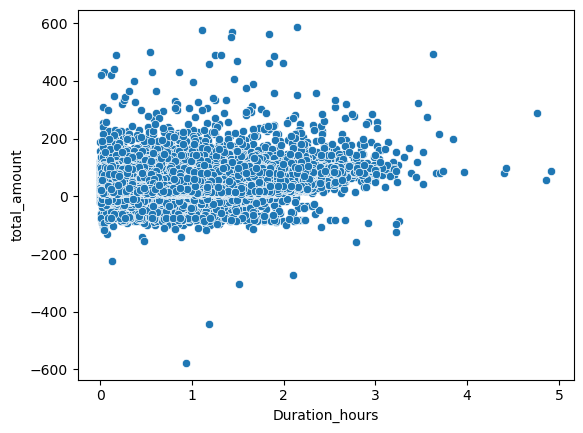

In [12]:
sns.scatterplot(x = X['Duration_hours'],y = X['total_amount'])

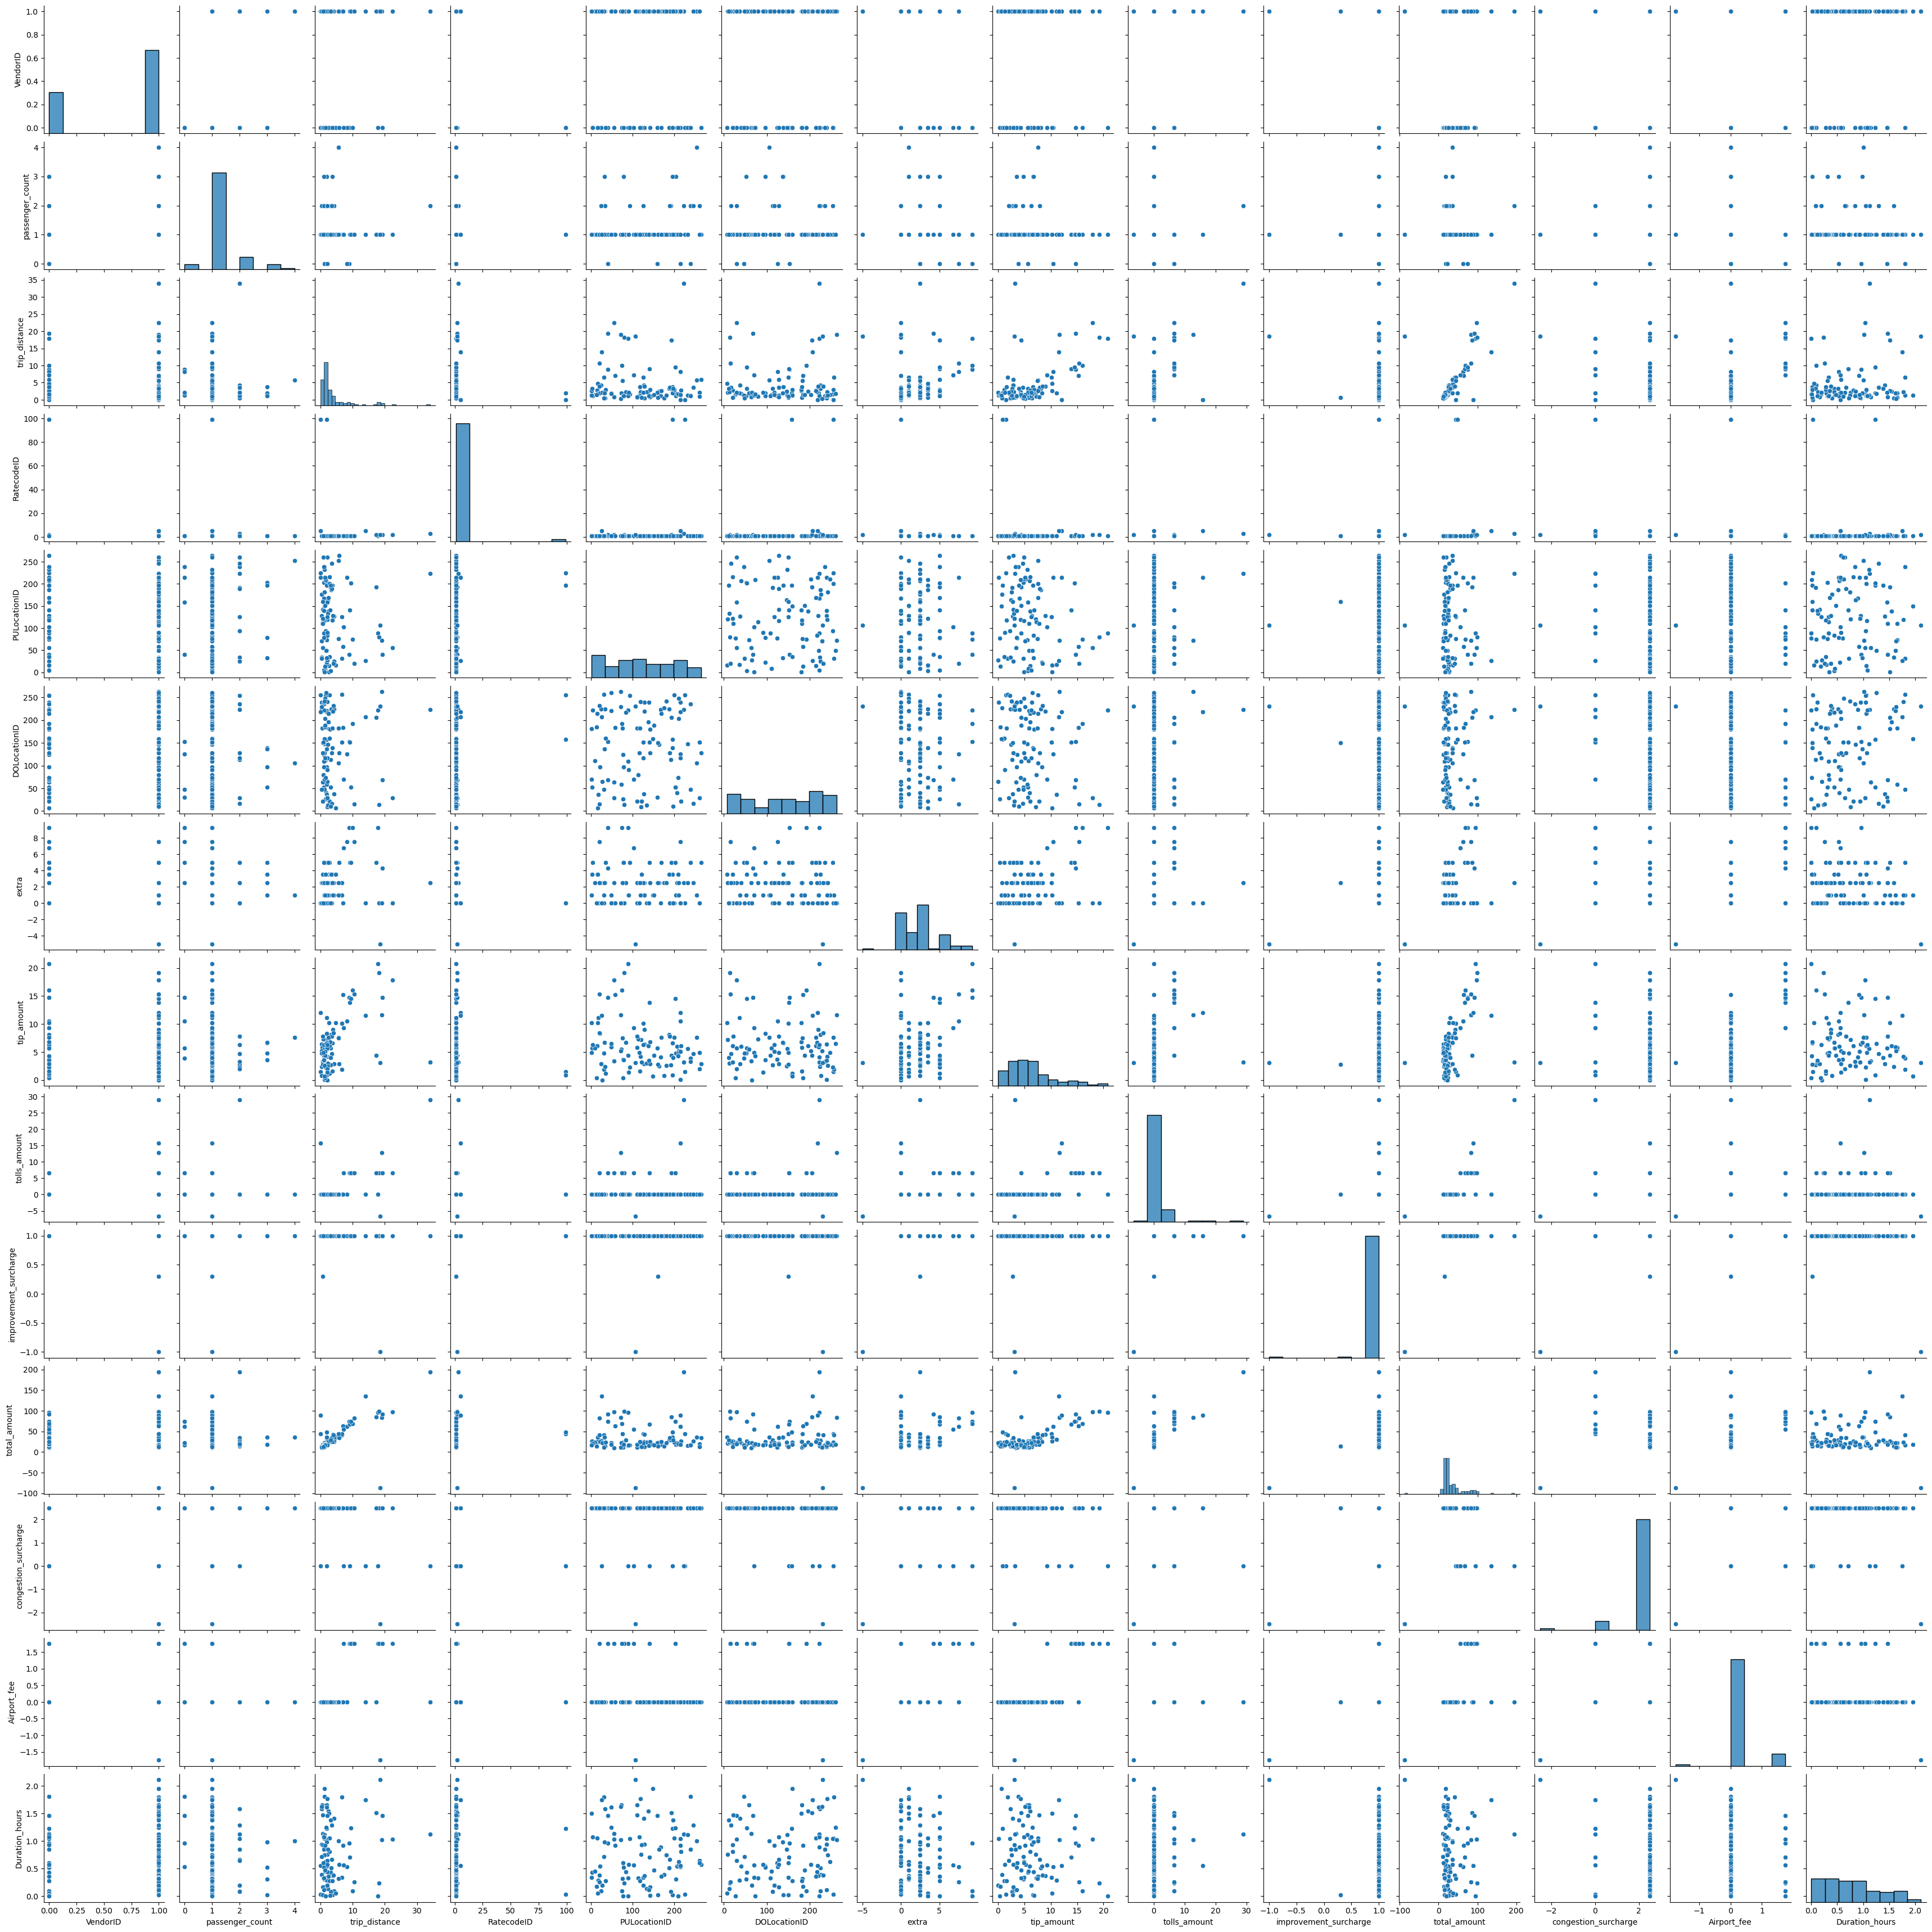

In [13]:
sns.pairplot(X.iloc[0:100,:])

In [14]:
y = X['total_amount']
X = X.drop(['total_amount','tpep_pickup_datetime','tpep_dropoff_datetime','Duration'], axis=1)

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174914 entries, 0 to 174999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               174914 non-null  int64  
 1   passenger_count        168837 non-null  float64
 2   trip_distance          174914 non-null  float64
 3   RatecodeID             168837 non-null  float64
 4   store_and_fwd_flag     168837 non-null  object 
 5   PULocationID           174914 non-null  int64  
 6   DOLocationID           174914 non-null  int64  
 7   payment_type           174914 non-null  object 
 8   extra                  174914 non-null  float64
 9   tip_amount             174914 non-null  float64
 10  tolls_amount           174914 non-null  float64
 11  improvement_surcharge  174914 non-null  float64
 12  congestion_surcharge   168837 non-null  float64
 13  Airport_fee            168837 non-null  float64
 14  Duration_hours         174914 non-nu

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.3, 
                                                    shuffle=True,
                                                    random_state=1)

In [17]:
def transform(df):   
    si = SimpleImputer()
    knn = KNNImputer()
    oe = OrdinalEncoder()
    le = LabelEncoder()
    ss = StandardScaler()
    mms = MinMaxScaler()
    
    df = pd.get_dummies(df,columns=['payment_type'],prefix='payment_type')

    cat_columns = df.select_dtypes(['object']).columns
    num_columns = df.select_dtypes(['int64','float64']).columns

    cat_pipe_steps = [('encoder',oe),('imputer',si),('scaler',ss)]
    num_pipe_steps = [('imputer',si),('scaler',ss)]

    cat_pipe = Pipeline(steps = cat_pipe_steps)
    num_pipe = Pipeline(steps = num_pipe_steps)

    preprocessor = ColumnTransformer(transformers=[('cat',cat_pipe,cat_columns),
                                                   ('num',num_pipe,num_columns)])
    df_transformed = preprocessor.fit_transform(df)
    
    return df_transformed

In [18]:
X_train_transformed = transform(X_train)
X_test_transformed = transform(X_test)

<AxesSubplot:>

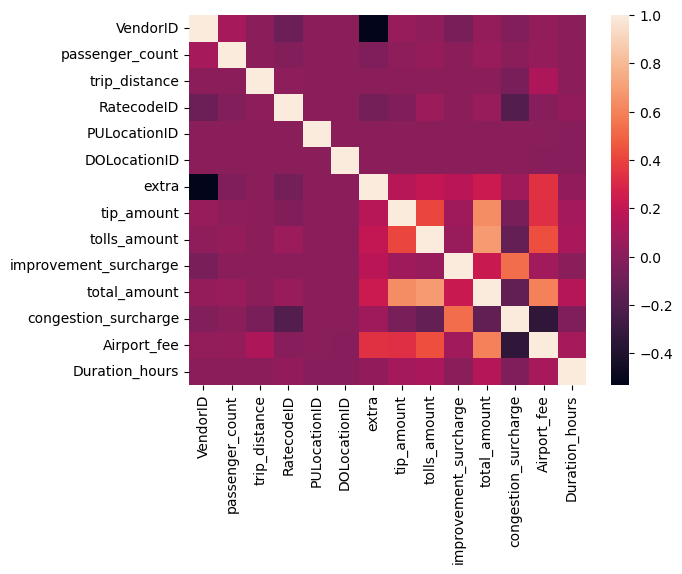

In [19]:
sns.heatmap(raw_data.corr())

In [20]:
lr = LinearRegression()
lr.fit(X_train_transformed,y_train)
lr.score(X_test_transformed,y_test)

0.723003566380612

In [21]:
lr.coef_

array([ 0.05236448,  0.24510715,  0.47778578,  0.07637916,  0.66408457,
        0.04449897,  0.01721389, -0.26689262,  9.59196752,  9.78657713,
        5.16856694, -2.14254594,  6.42978975,  1.28278767])

In [22]:
lr.intercept_

29.60298099461772

In [23]:
X_train.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'extra', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'congestion_surcharge', 'Airport_fee', 'Duration_hours'],
      dtype='object')

In [24]:
features = list(X_train.columns)

In [25]:
features.append('Bias/Intercept')

In [26]:
Coefficients = list(lr.coef_)
Coefficients.append(lr.intercept_)

In [27]:
features

['VendorID',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'extra',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'congestion_surcharge',
 'Airport_fee',
 'Duration_hours',
 'Bias/Intercept']

In [28]:
Coefficients

[0.05236447812079176,
 0.24510714830772706,
 0.4777857844758305,
 0.07637916475756092,
 0.6640845717521519,
 0.04449896786586246,
 0.017213886960696277,
 -0.26689262282639553,
 9.591967522982602,
 9.786577133781726,
 5.168566943177666,
 -2.14254594439978,
 6.429789747179658,
 1.2827876732543693,
 29.60298099461772]

In [29]:
X_train_transformed.shape

(122439, 14)

In [30]:
X_train.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'extra', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'congestion_surcharge', 'Airport_fee', 'Duration_hours'],
      dtype='object')